In [2]:
# get code
import os, sys
nevosim_path = os.path.abspath('../../../nevosim')
local_modules_path = os.path.abspath('../')
for package in (nevosim_path, local_modules_path):
    if package not in sys.path:
        sys.path.append(package)

from nevosim.networks import MutableNetwork
from nevosim.reactions import Reaction
from nevosim.algorithms import Simulation
from matplotlib import gridspec
from scipy.interpolate import griddata
import matplotlib.ticker as ticker

#from modules.data_handling import load, write, create_simulation_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
"""
Binding Network

Species:
0: Free Yan
1: Bound Yan
2: Free Pnt
3: Bound Pnt
4: Free Active Site

"""

'\nBinding Network\n\nSpecies:\n0: Free Yan\n1: Bound Yan\n2: Free Pnt\n3: Bound Pnt\n4: Free Active Site\n\n'

In [3]:
def get_coverage_analytically(A0=1, B0=1, S0=2, KdA=1, KdB=10):
    """
    Analytically computes equilibrium surface coverages for a system with two competitive binding substrates.
    
    Args:
    x (tuple) - initial concentrations of substrates A and B, e.g. (A0, B0)
    A0, B0, S0 (float) - initial concentrations of substrate A, substrate B, and binding sites
    KdA, KdB (float) - dissociation constants for substrates A and B
    
    Returns:
    theta_A, theta_B (float) - fractional surface coverage by substrates A and B
    """
    
    # coefficients
    a = KdA + KdB + A0 + B0 - S0
    b = KdB*(A0 - S0) + KdA*(B0-S0)+KdA*KdB
    c = -KdA*KdB*S0
    
    # compute coverages
    theta = np.arccos((-2*(a**3) + 9*a*b -27*c)/(2*np.sqrt(((a**2)-3*b)**3)))
    AS = A0 * ((2*np.sqrt((a**2) - 3*b)*np.cos(theta/3)) - a) / (3*KdA + (2*np.sqrt((a**2) - 3*b)*np.cos(theta/3)) - a)
    BS = B0 * ((2*np.sqrt((a**2) - 3*b)*np.cos(theta/3)) - a) / (3*KdB + (2*np.sqrt((a**2) - 3*b)*np.cos(theta/3)) - a)
    S = S0 - AS - BS
    
    return AS/S0, BS/S0

def analytical_solution_wrapper(x, *kwargs):
    """    
    Args:
    x (tuple) - initial concentrations of substrates A and B, e.g. (A0, B0)
    kwargs: S0, KdA, KdB
    
    Returns:
    series (pd Series) - length 2 series of fractional surface coverages by substrates A and B
    """
    a, b = get_coverage_analytically(x[0], x[1], *kwargs)
    return pd.Series({'yan_coverage': a, 'pnt_coverage': b})


# def get_coverage(x, total_sites=2, Kd_Y=1, Kd_P=10, plot=False):

#     total_yan, total_pnt = x
    
#     k_yan_association = 0.0001
#     k_pnt_association = 0.0001

#     yan_binding = Reaction(stoichiometry=[-1, 1, 0, 0, -1], k=k_yan_association)
#     yan_unbinding = Reaction(stoichiometry=[1, -1, 0, 0, 1], k=Kd_Y*k_yan_association)
#     pnt_binding = Reaction(stoichiometry=[0, 0, -1, 1, -1], k=k_pnt_association)
#     pnt_unbinding = Reaction(stoichiometry=[0, 0, 1, -1, 1], k=Kd_P*k_pnt_association)

#     rxns = [yan_binding, yan_unbinding, pnt_binding, pnt_unbinding]
#     cell = MutableNetwork(nodes=5, inputs=1, reactions=rxns, output_node=0)


#     ic = [total_yan, 0, total_pnt, 0, total_sites]
#     sim = Simulation(cell)
#     times, states = sim.simulate(ic, method='deterministic', dt=1, duration=10000, discrete=False)
    

#     yan_coverage = states[1, :] / total_sites
#     pnt_coverage = states[3, :] / total_sites
#     total_coverage = states[[1, 3], :].sum(axis=0) / total_sites
    
    
#     deriv = abs(total_coverage[-1] - total_coverage[-int(len(times)*0.25)]) / abs(times[-1]-times[-int(len(times)*0.25)])
#     if deriv > 1e-5:
#         return np.zeros(2)
    
#     if plot is True:
#         fig, ax = plt.subplots()
#         ax.plot(times, total_coverage, 'b', linewidth=5)
#         ax.plot(times, pnt_coverage, 'g', linewidth=5)
#         ax.plot(times, yan_coverage, 'g', linewidth=5)
#         ax.set_ylim(0, 1)

#     return pd.Series({'Yoverage': yan_coverage[-1], 'Pnt Coverage':pnt_coverage[-1]})

def cart2pol(xy_coords):
    x, y = xy_coords
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [rho, phi]

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return [x, y]

def normalize(data, background=None):

    if background is None:
        background = data
        
    data = data.astype(np.float)
    return (data - np.min(background)) / (np.max(background) - np.min(background))

def interpolate(x, y, z, density=100):
    """
    Interpolate data.
    """

    # remove nans
    x = x[np.isnan(z) == False]
    y = y[np.isnan(z) == False]
    z = z[np.isnan(z) == False]

    # define grid
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(xmin, xmax, density), np.linspace(ymin, ymax, density)
    xi, yi = np.meshgrid(xi, yi)

    # transform to normalized coordinates
    x_new, xi_new = normalize(x), normalize(xi, x)
    y_new, yi_new = normalize(y), normalize(yi, y)

    # interpolate data
    zi = griddata((x_new, y_new), z, (xi_new, yi_new), method='linear')

    return xi, yi, zi

def fill_patches(ax, xi, yi, zi, cmap=None, vmin=-1, vmax=1):
    """
    Add interpolated patches to axes.
    """

    # define colormap
    if cmap is None:
        cmap = plt.cm.get_cmap('coolwarm')
        cmap.set_bad('k', 1)

    # add data to plot
    zi = np.ma.masked_invalid(zi)
    im = ax.pcolormesh(xi, yi, zi, cmap=cmap, vmin=vmin, vmax=vmax)

    return im

def fmt_percentage(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    return r'{:2.0f}%'.format(x*100)

def compute_coverages(sampled_space, S0=2, KdA=1, KdB=10):
    data = sampled_space.merge(sampled_space[['total_yan', 'total_pnt']].apply(analytical_solution_wrapper, axis=1, args=(S0, KdA, KdB)), left_index=True, right_index=True)
    data['total_coverage'] = data[['yan_coverage', 'pnt_coverage']].sum(axis=1)
    data[['radius', 'angle']] = data[['total_pnt', 'total_yan']].apply(cart2pol, axis=1)
    return data

In [9]:
import numpy as np
qmax, num = 50, 100
y = np.tile(np.logspace(-2, np.log2(qmax), num=num, base=2).reshape(1, num), reps=(num, 1)).flatten()
p = np.tile(np.logspace(-2, np.log2(qmax), num=num, base=2).reshape(1, num).T, reps=(1, num)).flatten()

In [16]:
# compile sampled space (total yan and pnt ranges)
qmax, num = 100, 100
y = np.tile(np.logspace(-2, np.log2(qmax), num=num, base=2).reshape(1, num), reps=(num, 1)).flatten()
p = np.tile(np.logspace(-2, np.log2(qmax), num=num, base=2).reshape(1, num).T, reps=(1, num)).flatten()
sampled_space = pd.DataFrame(data={'total_yan': y, 'total_pnt': p, 'total_substrate': y+p, 'pnt_yan_ratio': p/y})

In [17]:
# compute surface coverages

data = compute_coverages(sampled_space, S0=2, KdA=1, KdB=1)

# data = sampled_space.merge(sampled_space[['total_yan', 'total_pnt']].apply(analytical_solution_wrapper, axis=1, args(S0)), left_index=True, right_index=True)
# data['total_coverage'] = data[['yan_coverage', 'pnt_coverage']].sum(axis=1)
# data[['radius', 'angle']] = data[['total_pnt', 'total_yan']].apply(cart2pol, axis=1)

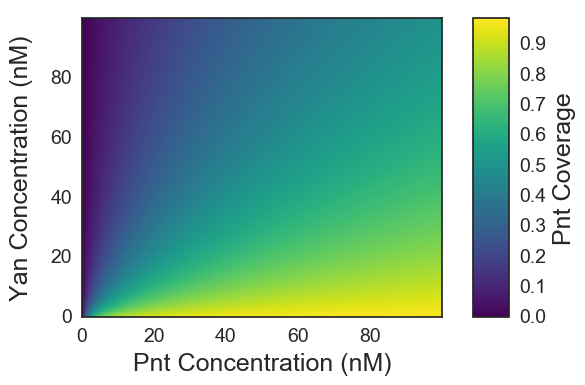

In [29]:
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, .1])

plotted_data = data[data['total_coverage'] > 0]

cmap0 = plt.cm.viridis

ax0 = plt.subplot(gs[0])
x, y, z = plotted_data['total_pnt'].values, plotted_data['total_yan'].values, plotted_data['pnt_coverage'].values
xi, yi, zi = interpolate(x, y, z, density=500)
im = fill_patches(ax0, xi, yi, zi, cmap=cmap0, vmin=0, vmax=z.max())


#scatter0 = ax0.scatter(x, y, alpha=1, c=z, cmap=cmap0, s=50, vmin=0, vmax=z.max(), linewidths=0)
ax0.set_xlim(0, data['total_pnt'].max()), ax0.set_ylim(0, data['total_yan'].max())
ax0.set_xlabel('Pnt Concentration (nM)', fontsize=18)
ax0.set_ylabel('Yan Concentration (nM)', fontsize=18)
ax0.tick_params(labelsize=14)

# add colorbar
cax0 = plt.subplot(gs[1])
cbar0 = plt.colorbar(im, orientation='vertical', cax=cax0)
cbar0.set_label('Pnt Coverage', fontsize=18)
cbar0.ax.tick_params(labelsize=14)
cbar0.update_ticks()
plt.tight_layout()

In [7]:
import seaborn as sns

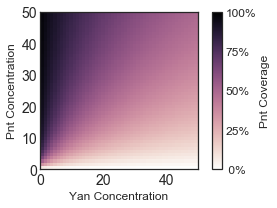

In [12]:
sns.set_style('white')

#fig = plt.figure(figsize=(4, 3))
#gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, .05])

fig, ax0 = plt.subplots(figsi)

plotted_data = data[data['total_coverage'] > 0]

cmap = sns.cubehelix_palette(8, light=1, dark=0, as_cmap=True)

ax0 = plt.subplot(gs[0])
x, y, z = plotted_data['total_yan'].values, plotted_data['total_pnt'].values, plotted_data['pnt_coverage'].values
xi, yi, zi = interpolate(x, y, z, density=50)
im = fill_patches(ax0, xi, yi, zi, cmap=cmap, vmin=0, vmax=1)


#scatter0 = ax0.scatter(x, y, alpha=1, c=z, cmap=cmap0, s=50, vmin=0, vmax=z.max(), linewidths=0)
ax0.set_xlim(0, data['total_pnt'].max()), ax0.set_ylim(0, data['total_yan'].max())
ax0.set_xlabel('Yan Concentration', fontsize=12)
ax0.set_ylabel('Pnt Concentration', fontsize=12)
#ax0.set_xticks([])
#ax0.set_yticks([])
ax0.set_aspect(1)
ax0.tick_params(labelsize=14)

# # add colorbar
# cax0 = plt.subplot(gs[1])
# cbar0 = plt.colorbar(im, orientation='vertical', cax=cax0)
# cbar0.set_label('Pnt Coverage', fontsize=12)
# cbar0.set_ticks(np.arange(0, 1.25, .25))
# cbar0.ax.tick_params(labelsize=12)
# cbar0.set_ticklabels(['{:2.0f}%'.format(100*x) for x in np.arange(0, 1.25, .25)])
# cbar0.update_ticks()
# plt.tight_layout()

# switch font rendering such that illustrator will receive editable text
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#fig.savefig('binding_equilibria_new.pdf', dpi=400, format='pdf')

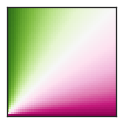

In [25]:
tickpad=2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['xtick.major.pad'] = tickpad
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['ytick.major.pad'] = tickpad
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['ytick.direction'] = 'in'

sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(2, 2))

plotted_data = data[data['total_coverage'] > 0]

cmap = plt.cm.PiYG
x, y, z = plotted_data['total_yan'].values, plotted_data['total_pnt'].values, plotted_data['pnt_coverage'].values
xi, yi, zi = interpolate(x, y, z, density=50)
im = fill_patches(ax0, xi, yi, zi, cmap=cmap, vmin=0, vmax=1)


#scatter0 = ax0.scatter(x, y, alpha=1, c=z, cmap=cmap0, s=50, vmin=0, vmax=z.max(), linewidths=0)
ax0.set_xlim(0, data['total_pnt'].max()), ax0.set_ylim(0, data['total_yan'].max())
#ax0.set_xlabel('Yan abundance')
#ax0.set_ylabel('Pnt abundance')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_aspect(1)

# switch font rendering such that illustrator will receive editable text
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig.savefig('binding_equilibria_new.pdf', dpi=400, format='pdf', rasterize=True)

In [ ]:
tickpad=2

In [35]:
cmap = sns.cubehelix_palette(8, as_cmap=True)

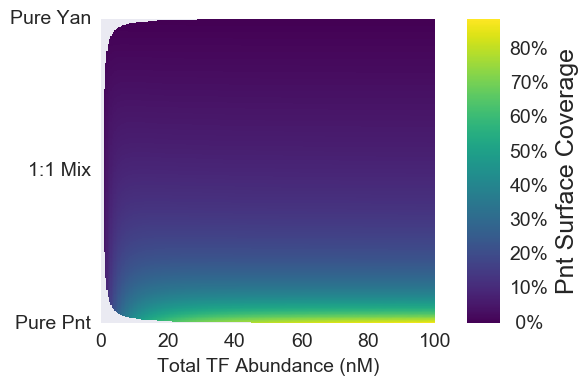

In [55]:
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, .1])

fig = plt.figure()
ax = plt.subplot(gs[0])

# interpolate and fill
#ax.scatter(data['Total Yan + Pnt'], data.angle, s=50, c=data['Pnt Coverage'], cmap=plt.cm.viridis, linewidths=0)
x, y, z = data['total_substrate'].values, data.angle.values, data['pnt_coverage'].values
xi, yi, zi = interpolate(x, y, z, density=500)
im = fill_patches(ax, xi, yi, zi, cmap=plt.cm.viridis, vmin=0, vmax=z.max())

# set yaxis label
ax.set_ylim(0, np.pi/2)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['Pure Pnt', '1:1 Mix', 'Pure Yan'])
ax.tick_params(labelsize=14)

# set xaxis label
ax.set_xlim(0, 100)
#ax.set_xlim(0, data['total_substrate'].max())
ax.set_xlabel('Total TF Abundance (nM)', fontsize=14)

# add colorbar
cax = plt.subplot(gs[1])
cbar = plt.colorbar(im, format=ticker.FuncFormatter(fmt_percentage), cax=cax, orientation='vertical')
cbar.set_label('Pnt Surface Coverage', fontsize=18)
cbar.ax.tick_params(labelsize=14)
cbar.update_ticks()
plt.tight_layout()

In [57]:
data_1 = compute_coverages(sampled_space, S0=2, KdA=1, KdB=10)
data_2 = compute_coverages(sampled_space, S0=2, KdA=1, KdB=1)
data_3 = compute_coverages(sampled_space, S0=2, KdA=10, KdB=1)

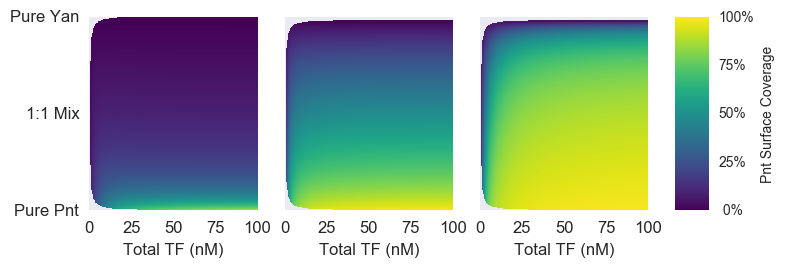

In [86]:
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[1, 1, 1, .2])

fig = plt.figure(figsize=(8, 2.5))

for i, current_data in enumerate([data_1, data_2, data_3]):
    
    ax = plt.subplot(gs[i])

    # interpolate and fill
    #ax.scatter(data['Total Yan + Pnt'], data.angle, s=50, c=data['Pnt Coverage'], cmap=plt.cm.viridis, linewidths=0)
    x, y, z = current_data['total_substrate'].values, current_data.angle.values, current_data['pnt_coverage'].values
    xi, yi, zi = interpolate(x, y, z, density=500)
    im = fill_patches(ax, xi, yi, zi, cmap=plt.cm.viridis, vmin=0, vmax=1)

    # set yaxis label
    if i == 0:
        ax.set_ylim(0, np.pi/2)
        ax.set_yticks([0, np.pi/4, np.pi/2])
        ax.set_yticklabels(['Pure Pnt', '1:1 Mix', 'Pure Yan'])
    else:
        ax.set_yticks([])
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.tick_params(labelsize=12)

    # set xaxis label
    ax.set_xlim(0, 100)
    #ax.set_xlim(0, data['total_substrate'].max())
    ax.set_xlabel('Total TF (nM)', fontsize=12)

# add colorbar
cax = plt.subplot(gs[3])
cbar = plt.colorbar(im, format=ticker.FuncFormatter(fmt_percentage), cax=cax, orientation='vertical')
cbar.set_label('Pnt Surface Coverage', fontsize=10)
cbar.set_ticks([0, .25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=10)
cbar.update_ticks()
#plt.tight_layout()